In [1]:
# Env
import os
from dotenv import load_dotenv
if not load_dotenv() or 'HOPSWORKS_API_KEY' not in os.environ:
    print("Please provide a .env file add HOPSWORKS_API_KEY to it.")
    exit(1)

# No warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"

# Imports
import seaborn as sns
sns.set_palette('husl')
import matplotlib.pyplot as plt
import hopsworks
import pandas as pd
import numpy as np
import math

# Heavy operation cache
from IPython.display import Image
from pathlib import Path
dir_plot_saves = "./plots"
# - Plots
Path(dir_plot_saves).mkdir(parents=True, exist_ok=True)
# Plot cache
def plot_or_cache(plotting_function, plot_name):
    plot_destination = f"{dir_plot_saves}/{plot_name}.png"
    if os.path.isfile(plot_destination):
        display(Image(filename=plot_destination))
    else:
        plotting_function()
        plt.savefig(plot_destination)
        plt.show()

# My help commands
from wine_training_help import evaluate_pca, train_evaluation

# 
import json
from hsfs.client.exceptions import RestAPIError

# IDE help
from hsfs import feature_store, feature_group, feature_view
from hsfs.constructor import query as hsfs_query

# Names
# - Models
model_red_wine_name = "wine_red_model"
model_red_wine_version = 1
model_white_wine_name = "wine_white_model"
model_white_wine_version = 1
# - Feature Groups
fg_wine_name = "wine"
fg_wine_version = 1
# fg_red_wine_name = "wine_red"
# fg_red_wine_version = 1
# fg_white_wine_name = "wine_white"
# fg_white_wine_version = 1
fg_type_red = "red"
fg_type_white = "white"

In [2]:
# Log in to Hopsworks and get feature store
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/201877
Connected. Call `.close()` to terminate connection gracefully.


In [3]:
try:
    wine_fg: feature_group.FeatureGroup = fs.get_feature_group(name=fg_wine_name, version=fg_wine_version)
    print(f"Wine data (version: {fg_wine_version}) gotten!")
except RestAPIError as e:
    try:
        response_json = json.loads(e.response.content)
    except Exception:
        response_json = []
    
    if "errorMsg" in response_json and response_json["errorMsg"] == "Featuregroup wasn\'t found.":
        print(f"Wine (version: {fg_wine_version}) does not exist on Hopsworks. (upload it first)")
        
    else:
        raise Exception(f"An unexpected RestAPIError happened: {e.response.content}")
except Exception as e:
    raise Exception(f"Something unexpected happened: {e}")

Wine data (version: 1) gotten!


In [4]:
wine_query: hsfs_query.Query = wine_fg.select_all()
wine_query

In [5]:
wine_df: pd.DataFrame = wine_query.read()
wine_red_df = wine_df[wine_df["type"] == fg_type_red]
wine_red_df = wine_red_df.drop(columns=["type"])
wine_red_df

Finished: Reading data from Hopsworks, using ArrowFlight (1.16s) 


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality
2,8.8,0.37,0.48,2.1,0.097,39.0,145.0,0.99750,3.04,1.03,9.3,5
9,8.8,0.59,0.18,2.9,0.089,12.0,74.0,0.99738,3.14,0.54,9.4,5
10,6.8,0.64,0.03,2.3,0.075,14.0,31.0,0.99545,3.36,0.58,10.4,6
19,6.3,0.68,0.01,3.7,0.103,32.0,54.0,0.99586,3.51,0.66,11.3,6
21,6.9,0.49,0.19,1.7,0.079,13.0,26.0,0.99547,3.38,0.64,9.8,6
...,...,...,...,...,...,...,...,...,...,...,...,...
5293,12.5,0.56,0.49,2.4,0.064,5.0,27.0,0.99990,3.08,0.87,10.9,5
5299,9.1,0.30,0.41,2.0,0.068,10.0,24.0,0.99523,3.27,0.85,11.7,7
5304,11.7,0.45,0.63,2.2,0.073,7.0,23.0,0.99974,3.21,0.69,10.9,6
5305,8.1,0.72,0.09,2.8,0.084,18.0,49.0,0.99940,3.43,0.72,11.1,6


# PCA

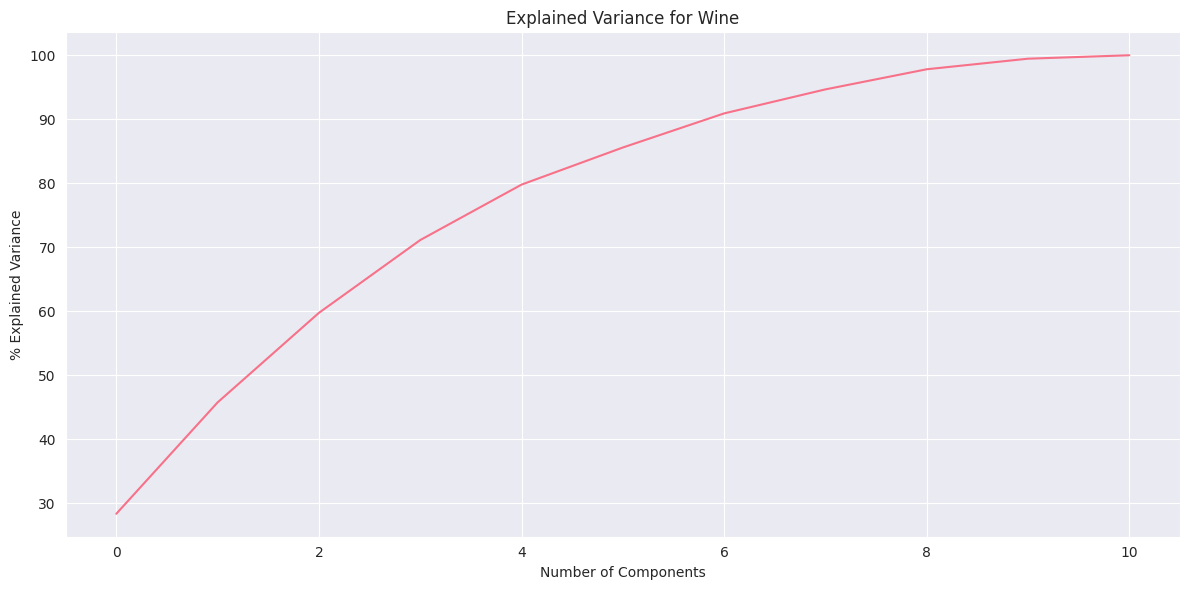

In [6]:
evaluate_pca(wine_red_df)

https://scribe.rip/@sanchitamangale12/scree-plot-733ed72c8608

If we should keep at least 80% of the total variance in the original dataset. Then it seems good to try 3-5 for the red wine.


Accuracy: 60.66%


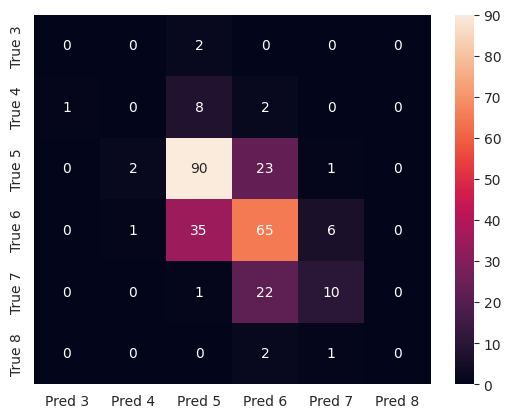

In [7]:
accuracy, df_cm = train_evaluation(wine_red_df, 'quality', use_model="RandomForestClassifier")
plt.figure()
cm = sns.heatmap(df_cm, annot=True)
cm.get_figure()
plt.show()

In [8]:
# 

In [9]:
def brute_force_check_RandomForestClassifier():
    df_acc = pd.DataFrame(columns=['PCA','Resample','Accuracy'])
    
    for i in [False] + list(range(3, 6)):
        for k in [False, "undersample", "oversample", "smote"]:
            cur_accuracy = train_evaluation(
                wine_red_df, 'quality', use_model="RandomForestClassifier", 
                use_pca_n_components=i,
                use_resampler=k,
                silent=True)
            print(f"Checked: PCA {i}, resample {k} -> {cur_accuracy}%")
            
            df_acc.loc[len(df_acc.index)] = [i, k, cur_accuracy]

    display(df_acc.sort_values(by='Accuracy', ascending=False))
    
brute_force_check_RandomForestClassifier()

Checked: PCA False, resample False -> 0.6066176470588235%
Checked: PCA False, resample undersample -> 0.33455882352941174%
Checked: PCA False, resample oversample -> 0.5808823529411765%
Checked: PCA False, resample smote -> 0.5330882352941176%
Checked: PCA 3, resample False -> 0.4889705882352941%
Checked: PCA 3, resample undersample -> 0.3014705882352941%
Checked: PCA 3, resample oversample -> 0.47058823529411764%
Checked: PCA 3, resample smote -> 0.36764705882352944%
Checked: PCA 4, resample False -> 0.5220588235294118%
Checked: PCA 4, resample undersample -> 0.27941176470588236%
Checked: PCA 4, resample oversample -> 0.5073529411764706%
Checked: PCA 4, resample smote -> 0.4117647058823529%
Checked: PCA 5, resample False -> 0.5404411764705882%
Checked: PCA 5, resample undersample -> 0.30514705882352944%
Checked: PCA 5, resample oversample -> 0.5294117647058824%
Checked: PCA 5, resample smote -> 0.4485294117647059%


,PCA,Resample,Accuracy
0,0,False,0.606618
2,0,oversample,0.580882
12,5,False,0.540441
3,0,smote,0.533088
14,5,oversample,0.529412
8,4,False,0.522059
10,4,oversample,0.507353
4,3,False,0.488971
6,3,oversample,0.470588
15,5,smote,0.448529


In [10]:
# Inspect #1 result with 56%

Accuracy: 54.04%


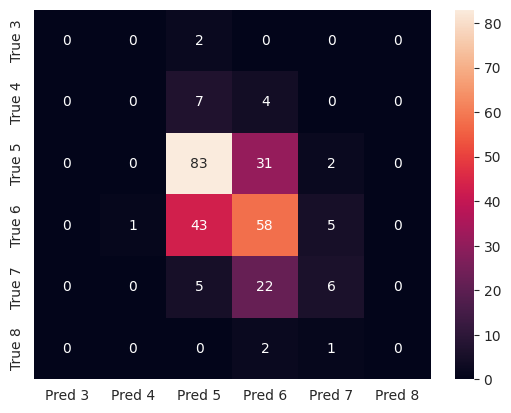

In [11]:
accuracy, df_cm = train_evaluation(
    wine_red_df, 'quality', use_model="RandomForestClassifier", 
    use_resampler=False,
    use_pca_n_components=5)
plt.figure()
cm = sns.heatmap(df_cm, annot=True)
cm.get_figure()
plt.show()

In [12]:
# Adjusting categories
# It is probably not allowed, but as there are so few high or low ranking wines, 
# it may be difficult to train a model on this data. If the categories are adjusted to: 
# low, medium and high quality wines (just 3 categories), the model might perform better. 
# There are a lot of wines in the 5-6 range. So the categories can be:
# - Low: 0-5
# - Medium: 5-6
# - High: 6-10

Accuracy: 62.87%


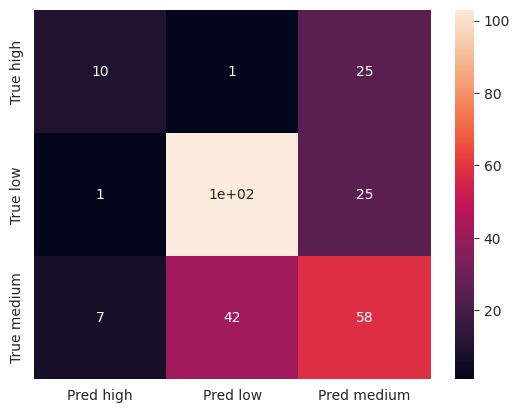

In [13]:
accuracy, df_cm = train_evaluation(
    wine_red_df, 'quality', use_model="RandomForestClassifier",
    classifier_adjust_categories=((0, 5, 6, 10), ['low', 'medium', 'high']))
plt.figure()
cm = sns.heatmap(df_cm, annot=True)
cm.get_figure()
plt.show()

In [14]:
def brute_force_check_RandomForestClassifier_adjust():
    df_acc = pd.DataFrame(columns=['PCA','Resample','Accuracy'])
    
    for i in [False] + list(range(3, 6)):
            for k in [False, "undersample", "oversample", "smote"]:
                cur_accuracy = train_evaluation(
                    wine_red_df, 'quality', use_model="RandomForestClassifier", 
                    classifier_adjust_categories=((0, 5, 6, 10), ['low', 'medium', 'high']),
                    use_pca_n_components=i,
                    use_resampler=k,
                    silent=True)
                print(f"Checked: PCA {i}, resample {k} -> {cur_accuracy}%")
                
                df_acc.loc[len(df_acc.index)] = [i, k, cur_accuracy]

    display(df_acc.sort_values(by='Accuracy', ascending=False))
    
brute_force_check_RandomForestClassifier_adjust()

Checked: PCA False, resample False -> 0.6286764705882353%
Checked: PCA False, resample undersample -> 0.5514705882352942%
Checked: PCA False, resample oversample -> 0.6286764705882353%
Checked: PCA False, resample smote -> 0.6176470588235294%
Checked: PCA 3, resample False -> 0.5404411764705882%
Checked: PCA 3, resample undersample -> 0.5404411764705882%
Checked: PCA 3, resample oversample -> 0.5404411764705882%
Checked: PCA 3, resample smote -> 0.5110294117647058%
Checked: PCA 4, resample False -> 0.5404411764705882%
Checked: PCA 4, resample undersample -> 0.5551470588235294%
Checked: PCA 4, resample oversample -> 0.5367647058823529%
Checked: PCA 4, resample smote -> 0.5514705882352942%
Checked: PCA 5, resample False -> 0.5845588235294118%
Checked: PCA 5, resample undersample -> 0.5772058823529411%
Checked: PCA 5, resample oversample -> 0.5808823529411765%
Checked: PCA 5, resample smote -> 0.5808823529411765%


,PCA,Resample,Accuracy
0,0,False,0.628676
2,0,oversample,0.628676
3,0,smote,0.617647
12,5,False,0.584559
14,5,oversample,0.580882
15,5,smote,0.580882
13,5,undersample,0.577206
9,4,undersample,0.555147
1,0,undersample,0.551471
11,4,smote,0.551471


In [15]:
# Inspect #2 result with 63%

Accuracy: 58.46%


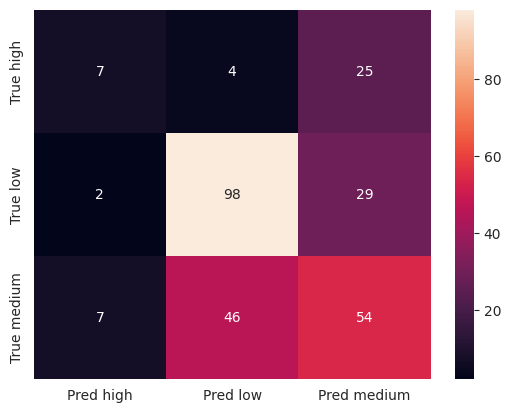

In [16]:
accuracy, df_cm = train_evaluation(
    wine_red_df, 'quality', use_model="RandomForestClassifier",
    use_resampler=False,
    use_pca_n_components=5,
    classifier_adjust_categories=((0, 5, 6, 10), ['low', 'medium', 'high']))
plt.figure()
cm = sns.heatmap(df_cm, annot=True)
cm.get_figure()
plt.show()